In [1]:
import sys
import os

sys.path.append(os.path.abspath('..'))

In [2]:
import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm

In [3]:
from NN_utils.Layers.Linear import Linear
from NN_utils.Activations.ReLU import ReLU
from NN_utils.Activations.Sigmoid import Sigmoid

from NN_utils.NeuralNetwork import NeuralNetwork

from NN_utils.Losses.BinaryCrossEntropy import BinaryCrossEntropy
from NN_utils.Losses.KLDivergence import KLDivergence

In [4]:
seed = 24
rng = np.random.default_rng(seed)

In [5]:
def load_data(path):
    with np.load(path) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']
        return (x_train, y_train), (x_test, y_test)

In [6]:
(x_train, y_train), (x_test, y_test) = load_data("../data/3. mnist.npz")

In [7]:
x_train = np.expand_dims(x_train, axis=1).astype(float)
x_test = np.expand_dims(x_test, axis=1).astype(float)
x_train /= 255.
x_test /= 255.

print(x_train.shape)
print(x_test.shape)

(60000, 1, 28, 28)
(10000, 1, 28, 28)


In [8]:
def display_images(images: np.ndarray, title: str, display_count: int) -> None:
    fig = plt.figure(figsize=(12, 10))
    fig.suptitle(title)
    for i in range(display_count):
        plt.subplot(4, 4, i + 1)
        plt.tight_layout()
        plt.imshow(np.transpose(images[i], (1, 2, 0)), cmap="gray")
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [9]:
batch_fixed = x_test[24:32]

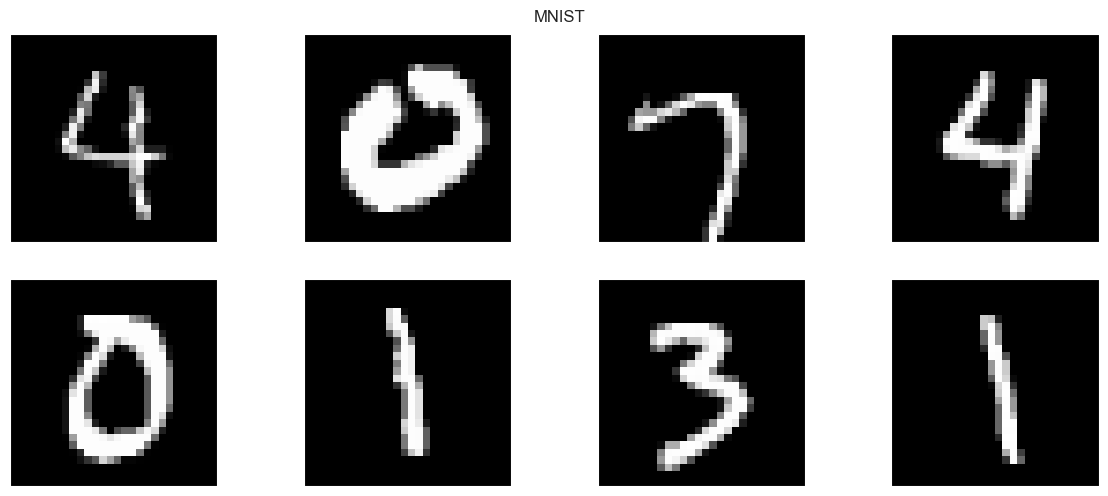

In [10]:
display_images(batch_fixed, 'MNIST', 8)

In [11]:
class Encoder:
    def __init__(self, input_dim: int = 784, latent_dim: int = 128, seed: int = 21):
        self.rng = np.random.default_rng(seed)

        self.Encoder = NeuralNetwork()
        self.Encoder.add(Linear(in_neurons=input_dim, out_neurons=512, random_seed=seed))
        self.Encoder.add(ReLU())
        self.Encoder.add(Linear(in_neurons=512, out_neurons=256, random_seed=seed))
        self.Encoder.add(ReLU())

        self.mu_layer = Linear(in_neurons=256, out_neurons=latent_dim, random_seed=seed)
        self.log_var_layer = Linear(in_neurons=256, out_neurons=latent_dim, random_seed=seed)

    def feedforward(self, x: np.ndarray) -> (np.ndarray, np.ndarray):
        curr_x = x.reshape(-1, 1)

        for layer in self.Encoder.layers:
            curr_x = layer.feedforward(curr_x)

        self.mu = self.mu_layer.feedforward(curr_x)
        self.log_var = self.log_var_layer.feedforward(curr_x)

        return self.mu, self.log_var

    def backprop(self, d_mu: np.ndarray, d_log_var: np.ndarray, lr: float) -> None:
        d_mu_enc = self.mu_layer.backprop(d_mu, lr=lr)
        d_log_var_enc = self.log_var_layer.backprop(d_log_var, lr=lr)

        d_curr = d_mu_enc + d_log_var_enc
        for layer in reversed(self.Encoder.layers):
            d_curr = layer.backprop(d_curr, lr=lr)

In [12]:
class Decoder:
    def __init__(self, input_dim: int = 784, latent_dim: int = 128, seed: int = 21):
        self.rng = np.random.default_rng(seed)

        self.Decoder = NeuralNetwork()
        self.Decoder.add(Linear(in_neurons=latent_dim, out_neurons=256, random_seed=seed))
        self.Decoder.add(ReLU())
        self.Decoder.add(Linear(in_neurons=256, out_neurons=512, random_seed=seed))
        self.Decoder.add(ReLU())
        self.Decoder.add(Linear(in_neurons=512, out_neurons=input_dim, random_seed=seed))
        self.Decoder.add(Sigmoid())

    def feedforward(self, x: np.ndarray) -> np.ndarray:
        curr_x = x
        for layer in self.Decoder.layers:
            curr_x = layer.feedforward(curr_x)

        return curr_x.reshape(1, 28, 28)

    def backprop(self, d_recon: np.ndarray, lr: float) -> np.ndarray:
        d_curr = d_recon.reshape(-1, 1)

        for layer in reversed(self.Decoder.layers):
            d_curr = layer.backprop(d_curr, lr=lr)

        return d_curr

In [13]:
class VAE:
    def __init__(self, input_dim: int = 784, latent_dim: int = 128, seed: int = 21) -> None:
        self.rng = np.random.default_rng(seed)

        self.encoder = Encoder(input_dim=input_dim, latent_dim=latent_dim, seed=seed)
        self.decoder = Decoder(input_dim=input_dim, latent_dim=latent_dim, seed=seed)

    def feedforward(self, x: np.ndarray) -> (np.ndarray, np.ndarray, np.ndarray):
        self.mu, self.log_var = self.encoder.feedforward(x)

        # Reparameterization trick
        std = np.exp(0.5 * self.log_var)
        eps = rng.standard_normal(std.shape)
        self.z = self.mu + eps * std

        return self.decoder.feedforward(self.z), self.mu, self.log_var

    def backprop(self, d_recon: np.ndarray, d_mu_kld: np.ndarray, d_log_var_kld: np.ndarray, lr: float) -> None:
        d_z = self.decoder.backprop(d_recon, lr=lr)

        # d_mu = d_z
        d_mu = d_z
        # d_log_var = d_z * 0.5 * eps * std (eps * std == z - mu)
        d_log_var = d_z * 0.5 * (self.z - self.mu)

        d_mu += d_mu_kld
        d_log_var += d_log_var_kld

        self.encoder.backprop(d_mu, d_log_var, lr)

In [14]:
class Discriminator:
    def __init__(self, input_dim: int = 784, latent_dim: int = 512, seed: int = 21) -> None:
        self.rng = np.random.default_rng(seed)

        self.layer_1 = Linear(in_neurons=input_dim, out_neurons=latent_dim)
        self.activation_1 = ReLU()
        self.layer_2 = Linear(in_neurons=latent_dim, out_neurons=128)
        self.activation_2 = ReLU()
        self.layer_3 = Linear(in_neurons=128, out_neurons=1)
        self.activation_3 = Sigmoid()

    def feedforward(self, x: np.ndarray) -> np.ndarray:
        x_curr = x.reshape(-1, 1)
        x_curr = self.layer_1.feedforward(x_curr)
        x_curr = self.activation_1.feedforward(x_curr)
        x_curr = self.layer_2.feedforward(x_curr)
        x_curr = self.activation_2.feedforward(x_curr)
        x_curr = self.layer_3.feedforward(x_curr)
        x_curr = self.activation_3.feedforward(x_curr)
        return x_curr

    def backprop(self, d_curr: np.ndarray, lr: float, update_params: bool = True) -> None:
        d_curr = self.activation_3.backprop(delta=d_curr, lr=lr)
        d_curr = self.layer_3.backprop(delta=d_curr, lr=lr, update_params=update_params)
        d_curr = self.activation_2.backprop(delta=d_curr, lr=lr)
        d_curr = self.layer_2.backprop(delta=d_curr, lr=lr, update_params=update_params)
        d_curr = self.activation_1.backprop(delta=d_curr, lr=lr)
        d_curr = self.layer_1.backprop(delta=d_curr, lr=lr, update_params=update_params)
        return d_curr.reshape(1, 28, 28)

In [15]:
vae = VAE(seed=seed)
discriminator = Discriminator(seed=seed)

In [16]:
bce_loss = BinaryCrossEntropy()
kld_loss = KLDivergence()

In [17]:
epochs = 1
lr = 1e-3

In [18]:
z_fixed = rng.standard_normal((8, 128, 1))
x_fixed = x_test[24:32]

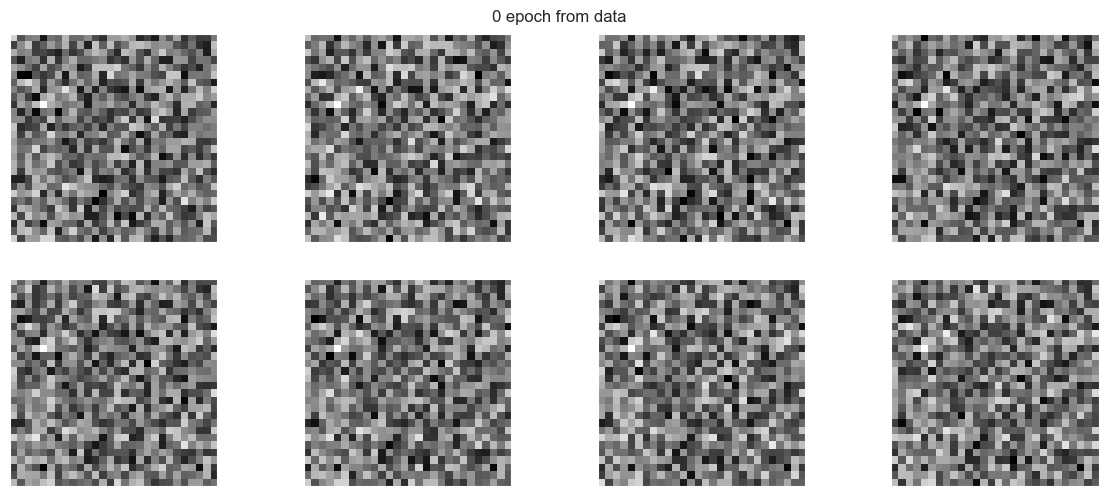

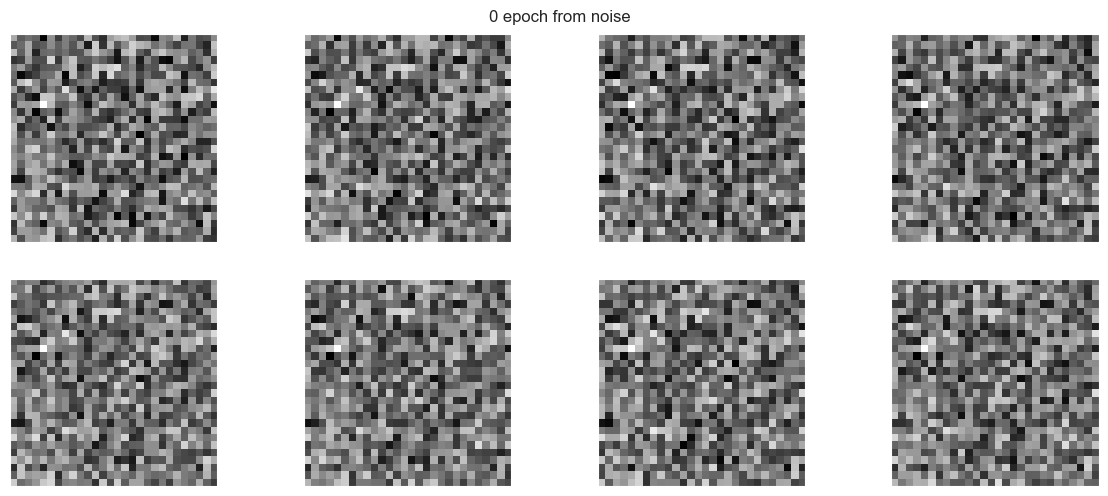

In [19]:
rec_from_data = np.zeros((8, 1, 28, 28))
rec_form_noise = np.zeros((8, 1, 28, 28))

for j in range(x_fixed.shape[0]):
    rec_from_data[j], _, _ = vae.feedforward(x_fixed[j])
    rec_form_noise[j] = vae.decoder.feedforward(z_fixed[j])

display_images(images=rec_from_data, title=f'0 epoch from data', display_count=8)
display_images(images=rec_form_noise, title=f'0 epoch from noise', display_count=8)

In [20]:
disc_real_loss_history = []
disc_fake_loss_history = []
disc_recon_loss_history = []

kld_loss_history = []
recon_loss_history = []
gen_loss_history = []

In [21]:
zeros_label = np.array([0])
ones_label = np.array([1])

In [22]:
def train(epochs: int = 10, lr: float = 1e-3) -> np.ndarray:
    for epoch in range(epochs):
        rng.shuffle(x_train)

        for i in tqdm(range(x_train.shape[0])):
            if i % 2 == 0:
                # Train discriminator
                ## Real image
                disc_real_pred = discriminator.feedforward(x_train[i])
                disc_real_loss_history.append(bce_loss.fn(ones_label, disc_real_pred))
                discriminator.backprop(d_curr=bce_loss.dfn(ones_label, disc_real_pred),
                                       lr=lr,
                                       update_params=True)
                ## Fake image
                recon_image, _, _ = vae.feedforward(x_train[i])
                disc_fake_pred = discriminator.feedforward(recon_image)
                disc_fake_loss_history.append(bce_loss.fn(zeros_label, disc_fake_pred))
                discriminator.backprop(d_curr=bce_loss.dfn(zeros_label, disc_fake_pred),
                                       lr=lr,
                                       update_params=True)
                ## Reconstructed image
                z_p = rng.standard_normal((128, 1))
                x_p = vae.decoder.feedforward(z_p)
                disc_recon_pred = discriminator.feedforward(x_p)
                disc_recon_loss_history.append(bce_loss.fn(zeros_label, disc_recon_pred))
                discriminator.backprop(d_curr=bce_loss.dfn(zeros_label, disc_recon_pred),
                                       lr=lr,
                                       update_params=True)

            else:
                # Train vae
                recon_image, mu, log_var = vae.feedforward(x_train[i])
                ## KLD loss
                kld_loss_history.append(kld_loss.fn(mu=mu, log_var=log_var))
                d_mu, d_log_var = kld_loss.dfn(mu=mu, log_var= log_var)
                ## Recon loss (BCE)
                recon_loss_history.append(np.mean(bce_loss.fn(x_train[i],recon_image)))
                d_recon_loss = bce_loss.dfn(x_train[i],recon_image)

                disc_pred = discriminator.feedforward(recon_image)
                gen_loss_history.append(bce_loss.fn(zeros_label, disc_pred))
                d_gen_loss = discriminator.backprop(d_curr=bce_loss.dfn(zeros_label,disc_pred),
                                                    lr=lr,
                                                    update_params=False)
                vae.backprop(d_recon=d_recon_loss + d_gen_loss, d_mu_kld=d_mu, d_log_var_kld=d_log_var, lr=lr)

        print(f'''
                Epoch {epoch + 1}/{epochs}"
        ''')
        for j in range(x_fixed.shape[0]):
            rec_from_data[j], _, _ = vae.feedforward(x_fixed[j])
            rec_form_noise[j] = vae.decoder.feedforward(z_fixed[j])

        display_images(images=rec_from_data, title=f'{epoch + 1} epoch from data', display_count=8)
        display_images(images=rec_form_noise, title=f'{epoch + 1} epoch from noise', display_count=8)

100%|██████████| 60000/60000 [13:12<00:00, 75.74it/s]



                Epoch 1/1"
        


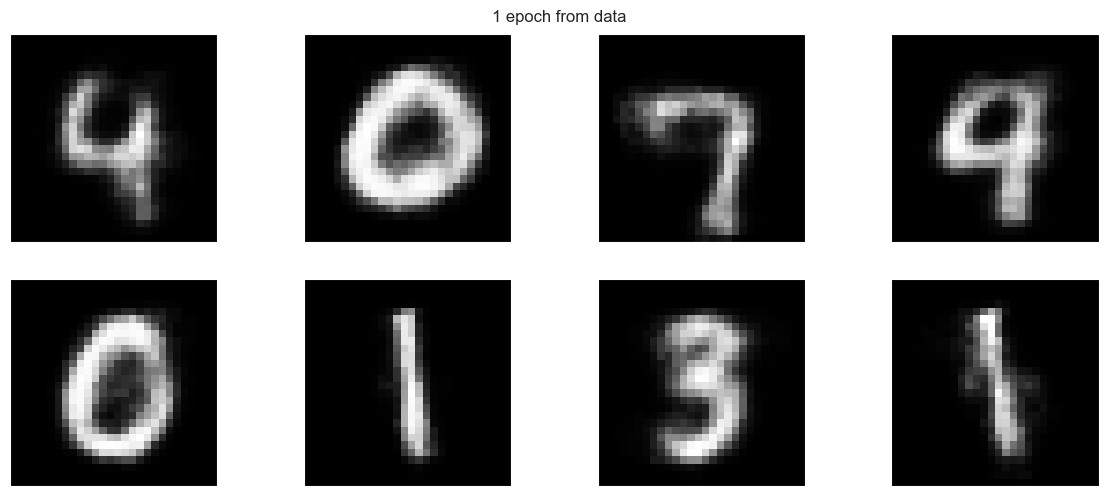

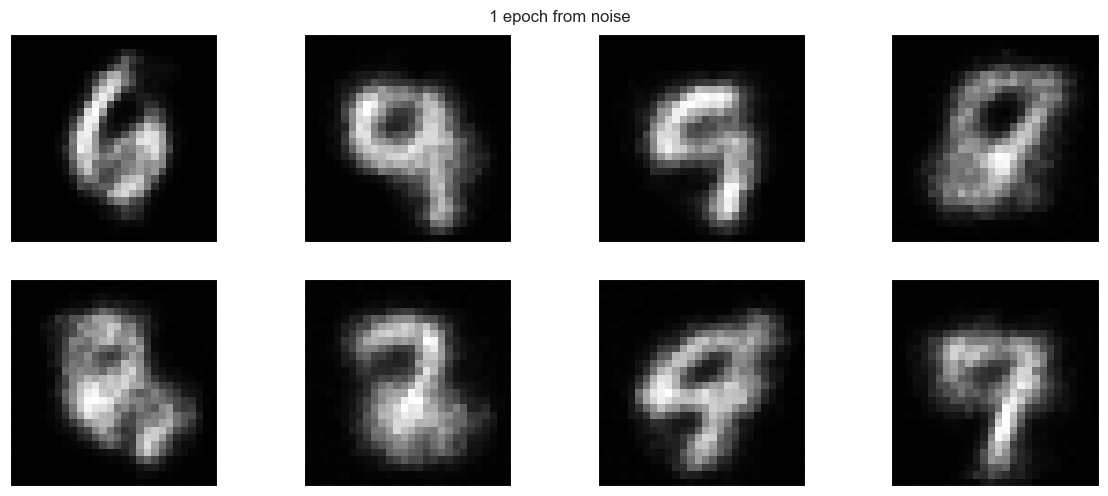

In [23]:
train(epochs=epochs,lr=lr)

Text(0.5, 0, 'Iterations')

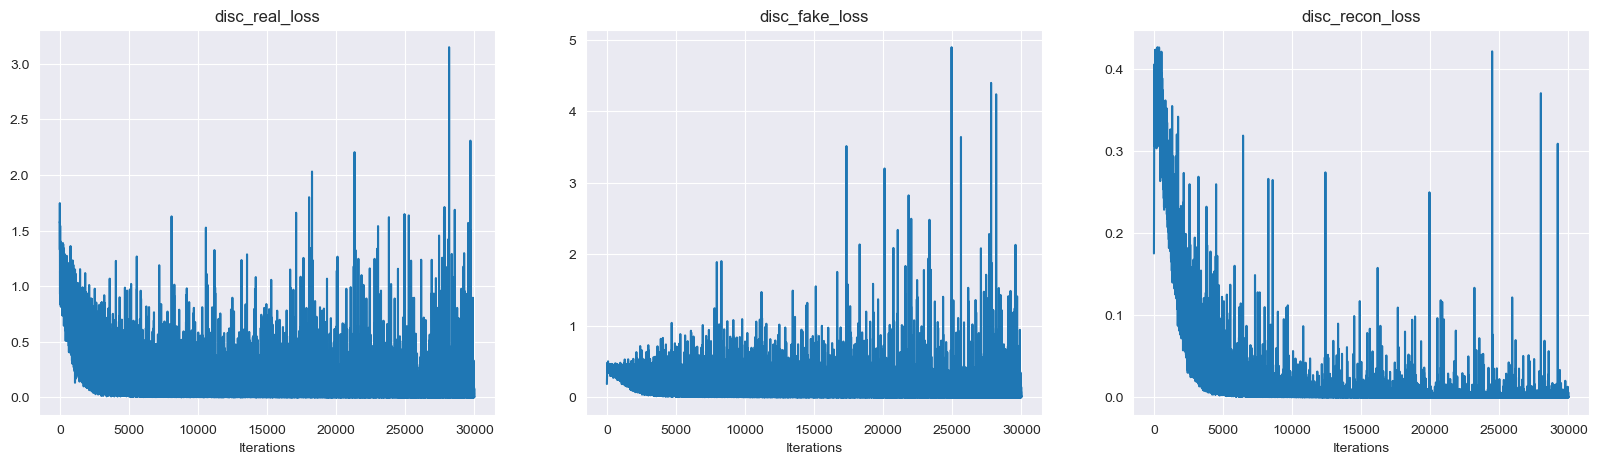

In [24]:
f, ax = plt.subplots(1,3, figsize=(20,5))

ax[0].plot(np.array(disc_real_loss_history).flatten())
ax[0].set_title("disc_real_loss")
ax[0].set_xlabel("Iterations")

ax[1].plot(np.array(disc_fake_loss_history).flatten())
ax[1].set_title("disc_fake_loss")
ax[1].set_xlabel("Iterations")

ax[2].plot(np.array(disc_recon_loss_history).flatten())
ax[2].set_title("disc_recon_loss")
ax[2].set_xlabel("Iterations")

Text(0.5, 0, 'Iterations')

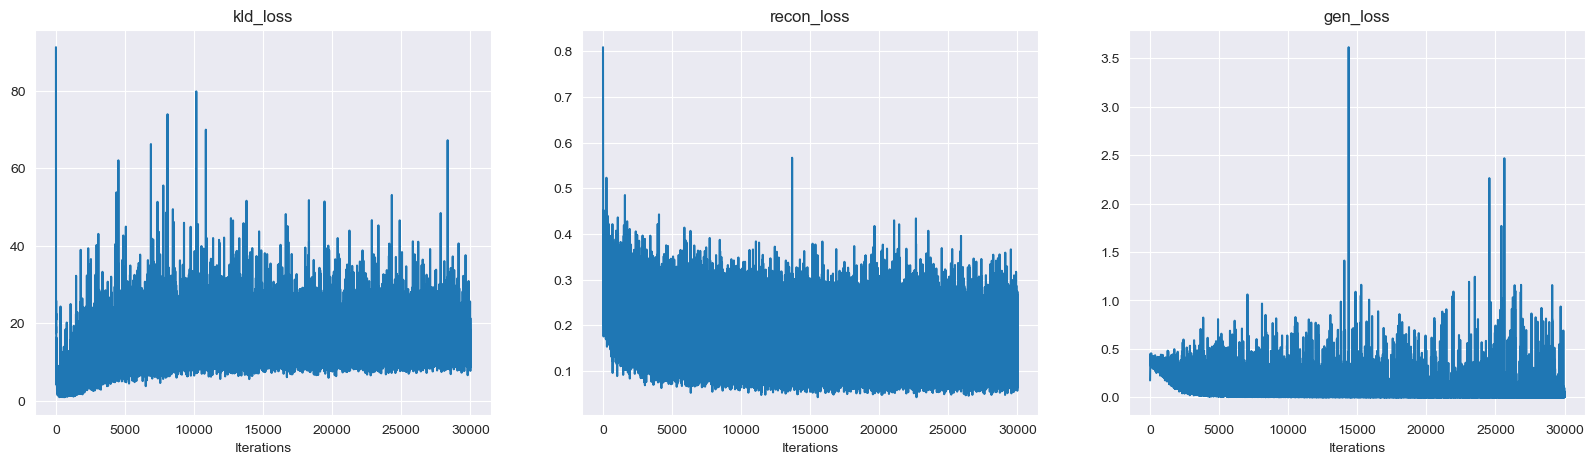

In [25]:
f, ax = plt.subplots(1,3, figsize=(20,5))

ax[0].plot(np.array(kld_loss_history).flatten())
ax[0].set_title("kld_loss")
ax[0].set_xlabel("Iterations")

ax[1].plot(np.array(recon_loss_history).flatten())
ax[1].set_title("recon_loss")
ax[1].set_xlabel("Iterations")

ax[2].plot(np.array(gen_loss_history).flatten())
ax[2].set_title("gen_loss")
ax[2].set_xlabel("Iterations")

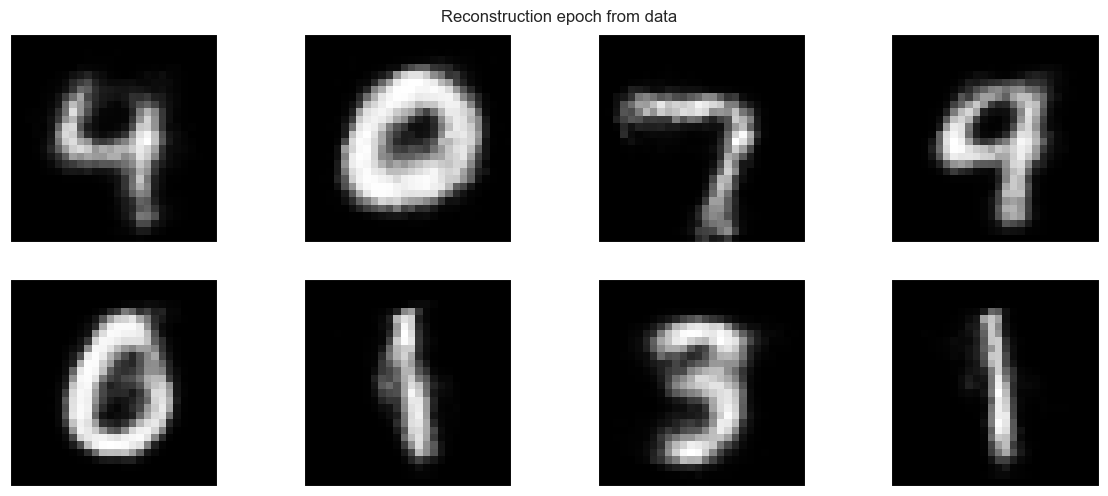

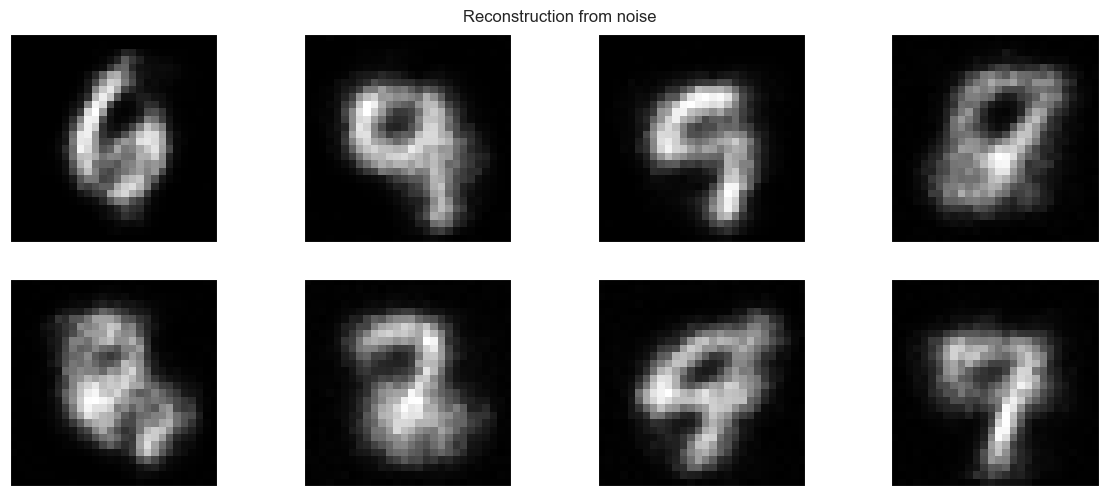

In [26]:
for j in range(x_fixed.shape[0]):
    rec_from_data[j], _, _ = vae.feedforward(x_fixed[j])
    rec_form_noise[j] = vae.decoder.feedforward(z_fixed[j])

display_images(images=rec_from_data, title=f'Reconstruction epoch from data', display_count=8)
display_images(images=rec_form_noise, title=f'Reconstruction from noise', display_count=8)